In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys


from clustpy.utils import plot_2d_data, plot_with_transformation

current_folder = globals()["_dh"][0]
parent_folder = os.path.dirname(current_folder)
print(parent_folder)
sys.path.append(parent_folder)

from data.densired_datasets import Datasets as DensiredDatasets
from data.real_world_datasets import Datasets as RealWorldDatasets


from src.Evaluation.dcdistances.dctree import DCTree

from src.Evaluation.CDBW.cdbw import cdbw_score as CDBW
from src.Evaluation.CVDD.cvdd import cvdd_score as CVDD
from src.Evaluation.DBCV.dbcv import dbcv_score as DBCV
from src.Evaluation.DCSI.dcsi import dcsi_score as DCSI
from src.Evaluation.DISCO.disco import disco_score as DISCO
from src.Evaluation.S_Dbw.sdbw import sdbw_score as S_DBW
from src.Evaluation.Silhouette.silhouette import silhouette_score as SILHOUETTE

from sklearn.metrics import silhouette_score as SILHOUETTE_SKLEARN
from sklearn.metrics import davies_bouldin_score as DB_SKLEARN
from sklearn.metrics import calinski_harabasz_score as CH_SKLEARN



METRICS = {
    "CDBW": CDBW,
    "CVDD": CVDD,
    "DBCV": lambda X, l: DBCV(X, l)[0],
    "DCSI": DCSI,
    "DISCO": DISCO,
    "S_DBW": S_DBW,
    "SILHOUETTE": SILHOUETTE,
    "SILHOUETTE_sklearn": SILHOUETTE_SKLEARN,
    "DAVIES BOULDIN_sklearn": DB_SKLEARN,
    "CALINSKI HARABASZ_sklearn": CH_SKLEARN,
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/mnt/data/pascalw777dm


In [3]:
from sklearn.neighbors import NearestNeighbors

def add_noise(X, l, n_noise, eps):
    noise = np.empty((n_noise, X.shape[1]))
    noise_too_near = np.array(range(len(noise)))
    while len(noise_too_near) > 0:
        noise[noise_too_near] = np.random.uniform(
            np.min(X, axis=0), np.max(X, axis=0), size=(len(noise_too_near), X.shape[1])
        )
        nbrs = NearestNeighbors(n_neighbors=1).fit(X)
        dists, _ = nbrs.kneighbors(noise)
        noise_too_near = np.where(dists < eps)[0]

    X_ = np.vstack((X, noise))
    l_ = np.hstack((l, np.array([-1] * len(noise))))
    
    return X_, l_

In [4]:
from sklearn.datasets import make_moons


def make_moons_random_assignment(n_samples, n_swap=0, seed=0):
    np.random.seed(seed)
    X, l = make_moons(n_samples=n_samples, random_state=seed, noise=0.0)
    # X, l = add_noise(X, l, 20, 0.1)
    class0 = np.where(l == 0)[0]
    class1 = np.where(l == 1)[0]
    choice_class0 = np.random.choice(len(class0), replace=False, size=n_swap)
    choice_class1 = np.random.choice(len(class1), replace=False, size=n_swap)
    l[class0[choice_class0]] = 1
    l[class1[choice_class1]] = 0
    return X, l

### twoMoonsDatasets[n_swap][run]
np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
twoMoonsDatasets = [
    [make_moons_random_assignment(100, n_swap=n_swap, seed=seed) for seed in random_seeds]
    for n_swap in range(0, 26)
]

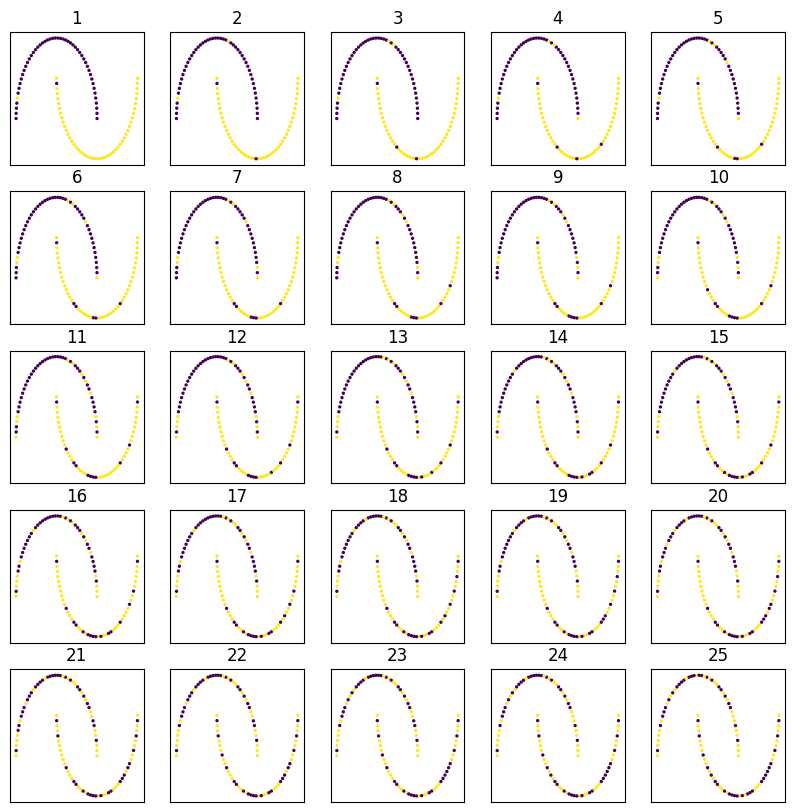

In [14]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(2*5, 2*5))
G = gridspec.GridSpec(5, 5)

for n_swap in range(0,25):
    ax = plt.subplot(G[n_swap // 5, n_swap % 5])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{n_swap+1}")
    X, l = twoMoonsDatasets[n_swap+1][0]
    plt.scatter(X[:, 0], X[:, 1], s=2, c=l)

In [5]:
from collections import defaultdict

eval_values = defaultdict(list)


def insert_dict(dict, measure_name, n_swap, run, value):
    dict["measure"].append(measure_name)
    dict["n_swap"].append(n_swap)
    dict["run"].append(run)
    dict["value"].append(value)


for n_swap in range(len(twoMoonsDatasets)):
    for run in range(len(twoMoonsDatasets[0])):
        X, l = twoMoonsDatasets[n_swap][run]
        for name, metric_fn in METRICS.items():
            insert_dict(eval_values, name, n_swap, run, metric_fn(X, l))

In [9]:
SELECTED_MEASURES = [
    "CDBW",
    "CVDD",
    "DBCV",
    "DCSI",
    "DISCO",
    "S_DBW",
    "SILHOUETTE",
    # "SILHOUETTE_sklearn",
    # "DAVIES BOULDIN_sklearn",
    # "CALINSKI HARABASZ_sklearn",
]

df = pd.DataFrame(data=eval_values)
df = df[df.measure.isin(SELECTED_MEASURES)]

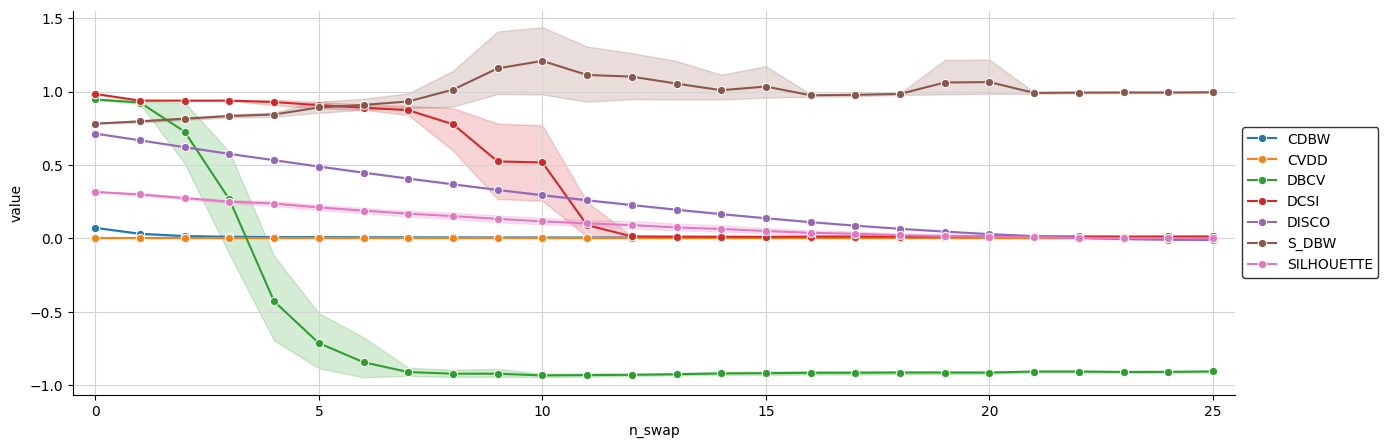

In [10]:
plt.figure(figsize=(15, 5))

ax = sns.lineplot(
    data=df,
    x="n_swap",
    y="value",
    hue="measure",
    # palette=sns.color_palette("bright"),
    marker="o",
)
ax.set_xlim((-0.5, 25.5))

ax.set_facecolor("white")

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("white")
ax.spines["top"].set_color("white")

ax.grid(color="lightgray")

leg = plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    # fontsize=19,
)

frame = leg.get_frame()
frame.set_facecolor("white")
frame.set_edgecolor("black")